# Save time by reusing regridder

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import ESMF
import xesmf as xe

## Prepare data

In [2]:
ds_in = xe.util.grid_2d(-120, 120, 0.4,
                        -60, 60, 0.3)
ds_in

<xarray.Dataset>
Dimensions:  (x: 600, x_b: 601, y: 400, y_b: 401)
Coordinates:
    lon      (y, x) float64 -119.8 -119.4 -119.0 -118.6 -118.2 -117.8 -117.4 ...
    lat      (y, x) float64 -59.85 -59.85 -59.85 -59.85 -59.85 -59.85 -59.85 ...
    lon_b    (y_b, x_b) float64 -120.0 -119.6 -119.2 -118.8 -118.4 -118.0 ...
    lat_b    (y_b, x_b) float64 -60.0 -60.0 -60.0 -60.0 -60.0 -60.0 -60.0 ...
Dimensions without coordinates: x, x_b, y, y_b
Data variables:
    *empty*

In [3]:
ds_out = xe.util.grid_2d(-120, 120, 0.6,
                         -60, 60, 0.4)
ds_out

<xarray.Dataset>
Dimensions:  (x: 400, x_b: 401, y: 300, y_b: 301)
Coordinates:
    lon      (y, x) float64 -119.7 -119.1 -118.5 -117.9 -117.3 -116.7 -116.1 ...
    lat      (y, x) float64 -59.8 -59.8 -59.8 -59.8 -59.8 -59.8 -59.8 -59.8 ...
    lon_b    (y_b, x_b) float64 -120.0 -119.4 -118.8 -118.2 -117.6 -117.0 ...
    lat_b    (y_b, x_b) float64 -60.0 -60.0 -60.0 -60.0 -60.0 -60.0 -60.0 ...
Dimensions without coordinates: x, x_b, y, y_b
Data variables:
    *empty*

In [4]:
ds_in.coords['time'] = np.arange(1, 11)
ds_in.coords['lev'] = np.arange(1, 51)
ds_in['data2D'] = xe.data.wave_smooth(ds_in['lon'], ds_in['lat'])
ds_in['data4D'] = ds_in['time'] * ds_in['lev'] * ds_in['data2D']
ds_in

<xarray.Dataset>
Dimensions:  (lev: 50, time: 10, x: 600, x_b: 601, y: 400, y_b: 401)
Coordinates:
    lon      (y, x) float64 -119.8 -119.4 -119.0 -118.6 -118.2 -117.8 -117.4 ...
    lat      (y, x) float64 -59.85 -59.85 -59.85 -59.85 -59.85 -59.85 -59.85 ...
    lon_b    (y_b, x_b) float64 -120.0 -119.6 -119.2 -118.8 -118.4 -118.0 ...
    lat_b    (y_b, x_b) float64 -60.0 -60.0 -60.0 -60.0 -60.0 -60.0 -60.0 ...
  * time     (time) int64 1 2 3 4 5 6 7 8 9 10
  * lev      (lev) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
Dimensions without coordinates: x, x_b, y, y_b
Data variables:
    data2D   (y, x) float64 1.872 1.869 1.866 1.863 1.86 1.857 1.855 1.852 ...
    data4D   (time, lev, y, x) float64 1.872 1.869 1.866 1.863 1.86 1.857 ...

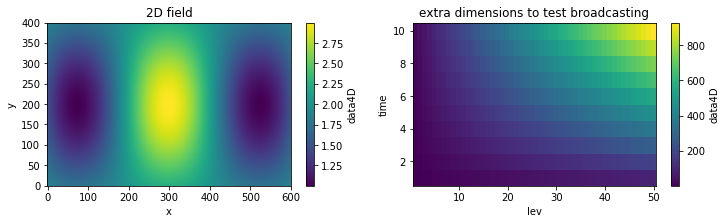

In [18]:
plt.figure(figsize=[12, 3])

plt.subplot(121)
ds_in['data4D'].isel(time=0, lev=0).plot()
plt.title('2D field')

plt.subplot(122)
ds_in['data4D'].mean(dim=['x','y']).plot()
plt.title('extra dimensions to test broadcasting')

## Build Regridder

In [6]:
%%time
regridder = xe.Regridder(ds_in, ds_out, 'bilinear')

Overwrite existing file: bilinear_400x600_300x400.nc 
 You can set reuse_weights=True to save computing time.
CPU times: user 6.66 s, sys: 310 ms, total: 6.97 s
Wall time: 6.99 s


In [7]:
regridder

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_400x600_300x400.nc 
Reuse pre-computed weights? False 
Input grid shape:           (400, 600) 
Output grid shape:          (300, 400) 
Output grid dimension name: ('y', 'x') 
Periodic in longitude?      False

## Apply regridding

In [8]:
ds_in['data4D'].nbytes / 1e9 # ~1GB

0.96

In [9]:
%%time
dr_out = regridder(ds_in['data4D'])

CPU times: user 404 ms, sys: 128 ms, total: 532 ms
Wall time: 538 ms


## Retrieve regridder

In [10]:
%%time
xe.Regridder(ds_in, ds_out, 'bilinear')

Overwrite existing file: bilinear_400x600_300x400.nc 
 You can set reuse_weights=True to save computing time.
CPU times: user 6.61 s, sys: 273 ms, total: 6.88 s
Wall time: 6.9 s


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_400x600_300x400.nc 
Reuse pre-computed weights? False 
Input grid shape:           (400, 600) 
Output grid shape:          (300, 400) 
Output grid dimension name: ('y', 'x') 
Periodic in longitude?      False

In [11]:
%%time
regridder2 = xe.Regridder(ds_in, ds_out, 'bilinear', reuse_weights=True)

Reuse existing file: bilinear_400x600_300x400.nc
CPU times: user 23.1 ms, sys: 6.47 ms, total: 29.6 ms
Wall time: 28.3 ms


In [12]:
%%time
dr_out2 = regridder2(ds_in['data4D'])

CPU times: user 426 ms, sys: 127 ms, total: 553 ms
Wall time: 554 ms


In [13]:
xr.testing.assert_identical(dr_out, dr_out2)

## How large it is?

In [14]:
regridder.filename

'bilinear_400x600_300x400.nc'

In [15]:
%%bash
du -sh bilinear_400x600_300x400.nc

7.3M	bilinear_400x600_300x400.nc
